In [1]:
%pip install simpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import simpy
import random
import statistics
from collections import deque
import pandas as pd
import datetime
import numpy as np
from itertools import chain

In [12]:
# Params and constants. In minutes

#Global Simpy env variables
SEED = 1234

#Ryan testing 4 hours
SIM_TIME = 60 * 8  # 8 hours of operation #can add a scalar like .5 for testing with a shorter time and to preserve the times in dict below

#Variables for project analysis
HEADWAY = 5 # Cyclical minutes between each train's arrival. Constant set by monorail's operators
DWELL_TIME = 3 # Minutes that a train remains in the station to allow for passenger loading. Constant set by monorail's operators
CAR_CAPACITY = 10 # Number of passengers that the park's model of trains car can hold.
CARS_PER_TRAIN = 3 # Number of train cars coupled together

# Schedule to define peak times throughout park open hours, in 30 min intervals
# Assume empiral data collection determined a peak in the morning at opening time, then again around lunch when people leave and come back. It tapers out like a tail to end the day
arrival_schedule = {1: 15, 2: 12, 3: 10, 4: 5, # First two hours, 8AM to 10AM
                    5: 3, 6: 4, 7: 3, 8: 6, # Next two hours, 10AM to 12PM
                    9: 25, 10: 22, 11: 14, 12: 8, # Next two hours, 12PM to 2PM
                    13: 6, 14: 4, 15: 3 , 16: 1# Final two hours, 2PM to4PM
                    }


In [13]:
def passenger_arrivals(env, store, headway, dwell_time, pax_queue, pax_id_list, pax_arrival_times, train_at_creation):
    """ Simpy function to generate passenger arrivals at the station platform and add to the FIFO queue"""
    pax_counter = 0

    
    while True:
        #Determine which interval the clock is in, 30 min intervals
        #Ryan testing 15 mins
        interval = (env.now // 30) + 1
        pax_interarrival = random.expovariate(arrival_schedule[interval]*.05) #Scalar to reduce compute time
        yield env.timeout(pax_interarrival)
        pax_counter += 1

        store.put(pax_counter)
        
        pax_queue.append(pax_counter)
        pax_id_list.append(pax_counter)
        pax_arrival_times.append(env.now)
        train_at_creation.append(((env.now - dwell_time) // (headway)) + 1)
        
        
        mins, seconds = divmod(env.now * 60, 60) #this time format only for printing

        #Debug | Report View
        #print(f"Passenger {pax_counter} arrived at t={int(mins)}:{int(seconds):02d} mins. {((env.now - dwell_time) // (headway)) + 1} ")


        

In [14]:
def train_arrival(env, store, pax_queue, pax_departure_times, train_at_departure, queue_len_snapshot, headway=HEADWAY, capacity=CAR_CAPACITY, n_cars=CARS_PER_TRAIN, dwell_time=DWELL_TIME):
    """ Simpy function to create the train arrivals at determined cadence"""
    total_capacity = capacity * n_cars
    train_counter = 0
    
    while True:
        
        yield env.timeout(HEADWAY)
        train_counter += 1

        #Jump into loading process function
        env.process(pax_loading(env, total_capacity, dwell_time, train_counter, store, pax_queue, pax_departure_times, train_at_departure, queue_len_snapshot))
        
        mins, seconds = divmod(env.now * 60, 60)  #this time format only for printing
        print(f"=={n_cars} Car monorail with capacity {total_capacity} pax and ID {train_counter} arrived at t={int(mins)}:{int(seconds):02d} mins==")

In [15]:
def pax_loading(env, total_capacity, dwell_time, train_counter, store, pax_queue, pax_departure_times, train_at_departure, queue_len_snapshot):
    """ Will remove people from the queue and load the train at a stochastic rate.
    Right now i have a uniform dist for testing values. we might want to change this to something more sophisticated
    """
    # Counter to keep track of pax loaded with each call of this function
    loaded = 0

    # # Helpful output
    # if len(pax_queue) != 0: #mind the case when a 0 len queue gives an index error
    #     print(f"ID starting platform queue = {pax_queue[0]}")
    # elif len(pax_queue) == 0:
    #     print(f"Waiting for passengers on platform!")
        
    # print(f"==Monorail dwells and loads for max of {dwell_time} mins==")

    #Elapsed times variables
    train_arrival_time = env.now
    train_departure_time = float(env.now + dwell_time)

    # Repeats until dwell reached
    while env.now < train_departure_time:        
        # Condition for max capacity. ensures no more depart system
        if loaded == total_capacity:
            print(f"==Monorail capacity reached! Queue n={len(pax_queue)}. Sitting then leaving station in t={train_departure_time - env.now:.2f} mins==")
            yield env.timeout(train_departure_time - env.now) #Reaching capacity before dwell time, train must sit until set departure time

        # Condition for people up to capacity
        elif loaded < total_capacity:
            load_time = random.triangular(0, .5, .25)
            if env.now + load_time > train_departure_time:
                env.timeout(train_departure_time - env.now)
            else:
                #Waits for arrival if platform clear, or grabs from queue
                on_platform = store.get()
                #End time
                dwell_end = env.timeout(train_departure_time - env.now)
            
                condition = yield on_platform | dwell_end  
    
                if on_platform in condition:
                    yield env.timeout(load_time)
                    loaded += 1
                    #Debug | Report View
                    #print(f"Loaded passenger n={loaded} @ {env.now:.2f}")            
                    pax_queue.popleft()
                    
                    pax_departure_times.append(env.now)
                    train_at_departure.append(train_counter)
                    queue_len_snapshot.append(len(pax_queue)) 
                elif dwell_end in condition:
                     yield env.timeout(train_departure_time - env.now)
    
    print(f"==Dwell reached for train {train_counter}. Loaded {loaded} pax. Monorail departs at t={env.now}==")
    if len(pax_queue) != 0:
        print(f"Queue n={len(pax_queue)}. ID ending platform queue = {pax_queue[0]}")
    elif len(pax_queue) == 0:
        print(f"Platform cleared! Queue n={len(pax_queue)}.")

In [16]:

def repitition_func(n_reps):
    global_repitition = []
    global_pax_id_list = []
    global_pax_arrival_times = []
    global_pax_departure_times = []
    global_train_at_departure = []
    global_queue_len_snapshot = []
    global_train_at_creation = []
    
    for rep in range(n_reps):

        print("########## On repitition:", rep, "#################")
        
        #Stat collection data structures
        pax_id_list = []
        pax_arrival_times = []
        pax_departure_times = []
        train_at_departure = []
        queue_len_snapshot = []
        train_at_creation = []
        repitition = []
        
        pax_queue = deque() # FIFO queue to manage people arriving at and leaving in order. Stores pax id and arrival timestamp. Eg (id, time) or (4, 1.32)
        
        random.seed(datetime.datetime.now().timestamp())
        
        env = simpy.Environment()
        pax_store = simpy.Store(env)
        
        
        #Processes
        env.process(passenger_arrivals(env, pax_store, HEADWAY, DWELL_TIME, pax_queue, pax_id_list, pax_arrival_times, train_at_creation))
        env.process(train_arrival(env, pax_store, pax_queue, pax_departure_times, train_at_departure, queue_len_snapshot))
        
        
        env.run(until=SIM_TIME)
        repitition = [rep] * len(pax_id_list)

        # Attempt to make all lists the same length
        pax_departure_times = pax_departure_times + [None] * (len(pax_arrival_times) - len(pax_departure_times))
        train_at_departure = train_at_departure + [None] * (len(pax_arrival_times) - len(train_at_departure))
        queue_len_snapshot = queue_len_snapshot + [None] * (len(pax_arrival_times) - len(queue_len_snapshot))

        #Appends to lists outside of loop
        global_repitition.append(repitition)
        global_pax_id_list.append(pax_id_list)
        global_pax_arrival_times.append(pax_arrival_times)
        global_pax_departure_times.append(pax_departure_times)
        global_train_at_departure.append(train_at_departure)
        global_queue_len_snapshot.append(queue_len_snapshot)
        global_train_at_creation.append(train_at_creation)


    #Returns dict of lists of lists. Could be exploded with something like a list comprehension or itertools.chain() before creating a pandas df
    return_dict = {
    'global_repitition' : global_repitition,
    'global_pax_id_list' : global_pax_id_list,
    'global_pax_arrival_times': global_pax_arrival_times,
    'global_pax_departure_times': global_pax_departure_times,
    'global_train_at_departure': global_train_at_departure,
    'global_queue_len_snapshot': global_queue_len_snapshot,
    'global_train_at_creation': global_train_at_creation,
    }

    return return_dict
    

In [17]:
#Actually running the simulation here
sim_data = repitition_func(5)

########## On repitition: 0 #################
==3 Car monorail with capacity 30 pax and ID 1 arrived at t=5:00 mins==
==Dwell reached for train 1. Loaded 2 pax. Monorail departs at t=8.0==
Platform cleared! Queue n=0.
==3 Car monorail with capacity 30 pax and ID 2 arrived at t=10:00 mins==
==Dwell reached for train 2. Loaded 2 pax. Monorail departs at t=13.25191314462603==
Queue n=1. ID ending platform queue = 5
==3 Car monorail with capacity 30 pax and ID 3 arrived at t=15:00 mins==
==Dwell reached for train 3. Loaded 7 pax. Monorail departs at t=18.005207165380828==
Queue n=1. ID ending platform queue = 12
==3 Car monorail with capacity 30 pax and ID 4 arrived at t=20:00 mins==
==Dwell reached for train 4. Loaded 4 pax. Monorail departs at t=23.0==
Queue n=1. ID ending platform queue = 16
==3 Car monorail with capacity 30 pax and ID 5 arrived at t=25:00 mins==
==Dwell reached for train 5. Loaded 3 pax. Monorail departs at t=28.0==
Queue n=2. ID ending platform queue = 19
==3 Car mono

In [18]:
#Since the data is collected in lists of list, this converts to flat lists for later on Pandas analysis

flat_sim_data = dict()

for key in sim_data.keys():
    flat = list(chain.from_iterable(sim_data[key]))
    flat_sim_data[key] = flat

In [35]:
# Pandas

df = pd.DataFrame(flat_sim_data)
df.columns = [col.replace("global_", '') for col in df.columns]

df['time_in_system'] = df.pax_departure_times - df.pax_arrival_times
df['trains_elapsed'] = df.train_at_departure - df.train_at_creation
df['trains_elapsed'] = df['trains_elapsed'].clip(lower=0) #clip() ensures early arrials have an accurate elapsed count

df = df[['repitition', 'pax_id_list', 'pax_arrival_times', 'pax_departure_times', 'time_in_system', 'train_at_creation', 'train_at_departure', 'trains_elapsed', 'queue_len_snapshot']]
    


In [36]:
df.head(25)

,repitition,pax_id_list,pax_arrival_times,pax_departure_times,time_in_system,train_at_creation,train_at_departure,trains_elapsed,queue_len_snapshot
0,0,1,3.010844,5.233236,2.222393,1.0,1.0,0.0,0.0
1,0,2,7.511046,7.928792,0.417746,1.0,1.0,0.0,0.0
2,0,3,9.173201,12.602849,3.429648,2.0,2.0,0.0,1.0
3,0,4,12.444754,13.251913,0.807159,2.0,2.0,0.0,1.0
4,0,5,12.907196,15.368348,2.461151,2.0,3.0,1.0,5.0
5,0,6,13.810004,15.514942,1.704938,3.0,3.0,0.0,4.0
6,0,7,13.873720,15.753982,1.880262,3.0,3.0,0.0,3.0
7,0,8,14.121350,16.171409,2.050059,3.0,3.0,0.0,3.0
8,0,9,14.205088,16.361869,2.156781,3.0,3.0,0.0,2.0
9,0,10,15.205732,16.671385,1.465654,3.0,3.0,0.0,1.0


In [21]:
#Data Analysis
avg_sys_by_rep = df.groupby('repitition')['time_in_system'].mean().reset_index()
display(avg_sys_by_rep)

,repitition,time_in_system
0,0,59.992207
1,1,60.858123
2,2,65.807133
3,3,58.048812
4,4,66.909150


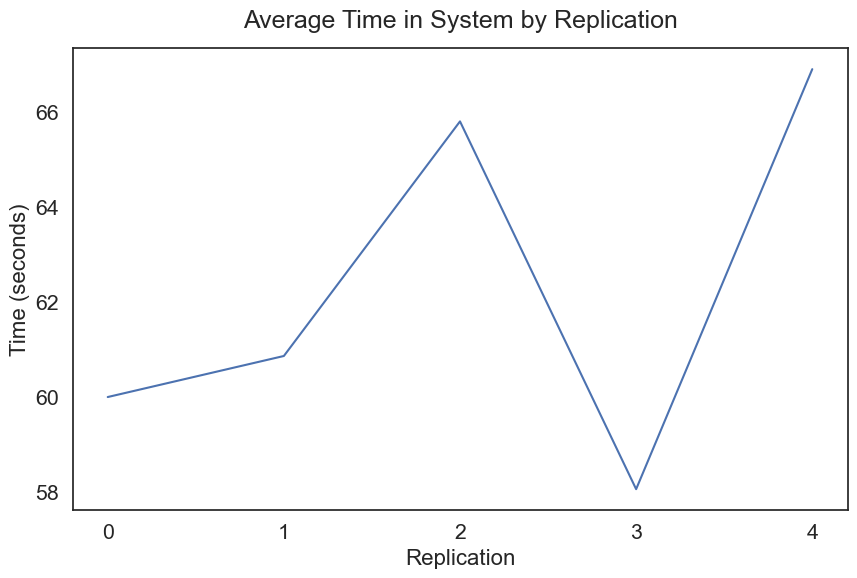

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", font_scale=1.4)

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=avg_sys_by_rep,
    x="repitition",
    y="time_in_system"
)
plt.xticks([0, 1, 2, 3, 4])

plt.title("Average Time in System by Replication", fontsize=18, pad=15)
plt.xlabel("Replication", fontsize=16)
plt.ylabel("Time (seconds)", fontsize=16)

plt.show()


In [ ]:
train utilization (passengers loaded per monorail arrival capacity)
"counts of trains-waited from overcrowding"

In [37]:
#Data Analysis
avg_trains_elapsed = df.groupby('repitition')['trains_elapsed'].sum().reset_index()
display(avg_trains_elapsed)

,repitition,trains_elapsed
0,0,1805.0
1,1,1488.0
2,2,1791.0
3,3,1582.0
4,4,1638.0


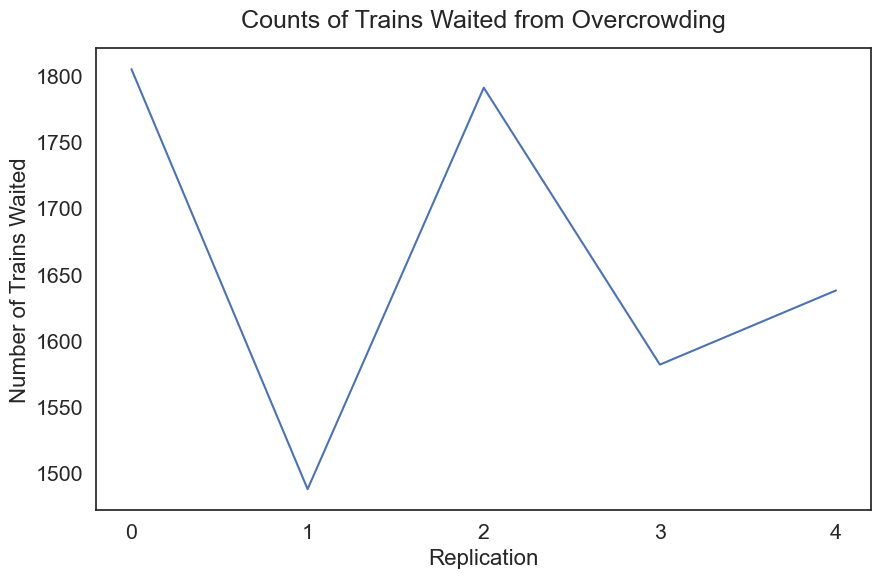

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", font_scale=1.4)

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=avg_trains_elapsed,
    x="repitition",
    y="trains_elapsed"
)
plt.xticks([0, 1, 2, 3, 4])

plt.title("Counts of Trains Waited from Overcrowding", fontsize=18, pad=15)
plt.xlabel("Replication", fontsize=16)
plt.ylabel("Number of Trains Waited", fontsize=16)

plt.show()
